In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import statistics as stat
import seaborn as sns

In [2]:
# Starting dataset
df = pd.read_csv('cleaned_dataframe.csv', sep='\t', index_col=0)

In [3]:
df.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,01/12/10 08:26,2.55,17850,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,01/12/10 08:26,3.39,17850,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,01/12/10 08:26,2.75,17850,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,01/12/10 08:26,3.39,17850,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,01/12/10 08:26,3.39,17850,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398767 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BasketID         398767 non-null  object 
 1   BasketDate       398767 non-null  object 
 2   Sale             398767 non-null  float64
 3   CustomerID       398767 non-null  int64  
 4   CustomerCountry  398767 non-null  object 
 5   ProdID           398767 non-null  object 
 6   ProdDescr        398767 non-null  object 
 7   Qta              398767 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 27.4+ MB


In [5]:
# Create the dataframe for customers
data = pd.core.frame.DataFrame({'CustomerID' : df['CustomerID'].unique()})
print("Number of unique customers: ", len(data))

Number of unique customers:  4333


In [7]:
unique_products = []
unique_products_ret = []
total_products = []
total_sale = []
total_sale_wret = []
total_prod_returned = []
min_prod_spent = []
max_prod_spent = []
total_orders = []
mean_prod_sale = []

#Discount shouldn't be part of products bought nor returned 
for customer in tqdm(df['CustomerID'].unique(), total=len(data), desc="Iterating over customers"):
    # use set ?
    # dividing filters instead of conjuncting them is MUCH FASTER
    df_temp = df.loc[df['CustomerID'] == customer, ['ProdID']].drop_duplicates()
    unique_products.append(len(df_temp.loc[df_temp['ProdID'] != 'D']))
    
    df_temp = df.loc[df['CustomerID'] == customer, ['ProdID', 'Qta']]
    df_temp = df_temp.loc[df['Qta'] < 0, ['ProdID']].drop_duplicates()
    unique_products_ret.append(len(df_temp.loc[df_temp['ProdID'] != 'D']))
    
    
    # discount are counted in total orders
    df_temp = df.loc[df['CustomerID'] == customer, ['BasketID', 'Qta']]
    df_temp = df_temp.loc[df['Qta'] > 0, ['BasketID']].drop_duplicates()
    total_orders.append(len(df_temp))
    
    # discount values are useful in meanps and tswr
    # discount values are NOT useful in mps, since they would always be the min value
    # discount values are useful in ts but have to be avoided in tp (not a real product)
    df_aux = df.loc[df['CustomerID'] == customer, ['Qta', 'Sale','ProdID']]
    tp = tpr = ts = tswr = 0
    mps = []
    meanps = []
    for _, r in df_aux.iterrows():
        cost = r['Qta']*r['Sale']
        tp += r['Qta'] if r['ProdID'] != 'D' else 0
        ts += cost
        if r['Qta'] > 0 or r['ProdID'] == 'D':
            tswr += cost
            meanps.append(r['Sale'])
            if r['Qta'] > 0: # not DISCOUNT
                mps.append(cost)
        else:
            tpr -= r['Qta']
            
    total_products.append(tp)
    total_prod_returned.append(tpr)
    total_sale.append(ts)
    total_sale_wret.append(tswr)
    min_prod_spent.append(min(mps))
    max_prod_spent.append(max(mps))
    mean_prod_sale.append(stat.fmean(meanps))

In [8]:
order_stats_per_customer = {} # key = customerID, value = list(max_products_order, min, mean_accum, max_spent_order, min, mean_accum, mean_counter) 
mean_counter = 0
data_about_order = df[['BasketID','CustomerID']].drop_duplicates()

######################################################################################################################################
#what about discount? no sense reasoning about those records if calculating max/min qta/sale, but reasonable to add them in mean calc#
######################################################################################################################################

for _, r in tqdm(data_about_order.iterrows(), total=len(data_about_order), desc="Iterating over orders"):
    customer = r["CustomerID"]
    order = r["BasketID"]
    df_aux = df.loc[df['BasketID'] == order, ['Qta','Sale','ProdID', 'CustomerID']]
    df_aux = df_aux.loc[df['CustomerID'] == customer, ['Qta','Sale','ProdID']]
    temp_prod = 0
    temp_sale = 0 
    
    for _, int_r in df_aux.iterrows():
        temp_prod += int_r['Qta']
        temp_sale += int_r['Qta']*int_r['Sale']
        
    is_neg = False
    if temp_prod < 0 or temp_sale < 0:
        is_neg = True  
    
    if customer not in order_stats_per_customer:
        order_stats_per_customer[customer] = [math.inf, math.inf, 0, math.inf, math.inf, 0, 0]
        
    if not is_neg:
        if order_stats_per_customer[customer][0] == math.inf or order_stats_per_customer[customer][0] < temp_prod:
            order_stats_per_customer[customer][0] = temp_prod
        if order_stats_per_customer[customer][1] == math.inf or order_stats_per_customer[customer][1] > temp_prod:
            order_stats_per_customer[customer][1] = temp_prod
        if order_stats_per_customer[customer][3] == math.inf or order_stats_per_customer[customer][3] < temp_sale:
            order_stats_per_customer[customer][3] = temp_sale
        if order_stats_per_customer[customer][4] == math.inf or order_stats_per_customer[customer][4] > temp_sale:
            order_stats_per_customer[customer][4] = temp_sale
            
    order_stats_per_customer[customer][2] += temp_prod
    order_stats_per_customer[customer][5] += temp_sale
    order_stats_per_customer[customer][6] += 1

In [9]:
max_spent_order_wise = []
min_spent_order_wise = []
mean_spent_order_wise = []
max_products_order_wise = []
min_products_order_wise = []
mean_products_order_wise = []

for customer in tqdm(df['CustomerID'].unique(), total=len(data), desc="Iterating over customers"):
    max_products_order_wise.append(order_stats_per_customer[customer][0])
    min_products_order_wise.append(order_stats_per_customer[customer][1])
    mean_products_order_wise.append(order_stats_per_customer[customer][2] / order_stats_per_customer[customer][6])
    max_spent_order_wise.append(order_stats_per_customer[customer][3])
    min_spent_order_wise.append(order_stats_per_customer[customer][4])
    mean_spent_order_wise.append(order_stats_per_customer[customer][5] / order_stats_per_customer[customer][6])

In [10]:
mean_order_month = []
mean_prod_month = []
mean_sale_month = []
for customer in tqdm(df['CustomerID'].unique(), total=len(data), desc="Iterating over customers"):
    order_per_month = []
    prod_per_month = []
    sale_per_month = []
    df_aux = df.loc[df['CustomerID'] == customer, ['BasketDate', 'BasketID', 'ProdID', 'Sale', 'Qta']]
    for month in range(1, 13):
        tot = 0
        orders = set()
        prods = set()
        for _, r in df_aux.iterrows():
             if r['BasketDate'][3:5] == str(month):
                orders.add(r['BasketID'])
                prods.add(r['ProdID'])
                tot += r['Qta']*r['Sale']
        order_per_month.append(len(orders))
        prod_per_month.append(len(prods))
        sale_per_month.append(tot)
    mean_order_month.append(stat.fmean(order_per_month))
    mean_prod_month.append(stat.fmean(prod_per_month))
    mean_sale_month.append(stat.fmean(sale_per_month))

In [40]:
#indicator on Shannon Entropy about sale*qta values on whole period of observation
entropy_saleqta = []

for customer in tqdm(df['CustomerID'].unique(), total=len(data), desc="Iterating over customers"):
    customer_entropy_counts = []
    
    df_aux = df.loc[df['CustomerID'] == customer, ['Sale', 'Qta']]
    for _, r in df_aux.iterrows():
        customer_entropy_counts.append(r['Qta']*r['Sale'])
    
    customer_entropy_prob = pd.core.frame.DataFrame({'cust_count': customer_entropy_counts}).value_counts(normalize=True)
    entropy_saleqta.append(stats.entropy(customer_entropy_prob, base = 2))

In [41]:
#indicator on Shannon Entropy about sale*qta values on whole period of observation (order based)
entropy_saleqta_order = []
for customer in tqdm(df['CustomerID'].unique(), total=len(data), desc="Iterating over customers"):
    
    basket_list = df[df['CustomerID'] == customer]['BasketID'].unique()
    customer_entropy_counts = []
    
    for basket in basket_list:
        df_aux = df[df['CustomerID'] == customer]
        df_aux = df_aux.loc[df_aux['BasketID'] == basket,['Sale','Qta']]
        accum = 0
        for _, r in df_aux.iterrows():
            accum += r['Qta']*r['Sale']
        customer_entropy_counts.append(accum)
    
    customer_entropy_prob = pd.core.frame.DataFrame({'cust_count': customer_entropy_counts}).value_counts(normalize=True)
    entropy_saleqta_order.append(stats.entropy(customer_entropy_prob, base = 2))

In [42]:
# I: the total number of items purchased by a customer during the period of observation.
data['TProd'] = total_products

In [43]:
# Iu: the number of distinct items bought by a customer in the period of observation.
data['DProd'] = unique_products

In [44]:
# Imax: the maximum number of items purchased by a customer during a shopping session
data['MaxPO'] = max_products_order_wise

In [45]:
# Imin: the minimum number of items purchased by a customer during a shopping session
data['MinPO'] = min_products_order_wise

In [47]:
# ProdPerOrderMean: mean number of items purchased by a customer during a shopping session
data['MeanProdOrder'] = mean_products_order_wise

In [48]:
# SaleTot: total amount spent during the period of observation
data['TSale'] = total_sale

In [49]:
# SaleTotWithoutReturn: total amount spent without negative quantity during the period of observation
data['TSaleWRet'] = total_sale_wret

In [50]:
# SaleMin: min amount spent for a product during the shopping session
data['MinPSale'] = min_prod_spent

In [51]:
# SaleMax: max amount spent for a product during the shopping session
data['MaxPSale'] = max_prod_spent

In [52]:
# SaleMeanPerOrder: mean amount spent for each order during the period of observation
data['MeanSaleOrder'] = mean_spent_order_wise

In [53]:
# NumRetProd: number of returned products in the period of observation
data['TRProd'] = total_prod_returned

In [54]:
# NumDistRetProd: number of distinct returned products in the period of observation
data['TRDProd'] = unique_products_ret

In [55]:
# MeanProdCostInOrder: mean cost of the products in the orders in the period of observation
data['MeanPSale'] = mean_prod_sale

In [56]:
# NumberOfOrders: total number of orders made by customer
data['TOrder'] = total_orders

In [57]:
# MeanOrderPerMonth
data['OrderMonth'] = mean_order_month

In [58]:
# MeanProductPerMonth
data['ProdMonth'] = mean_prod_month

In [59]:
# MeanAmountSpentPerMonth
data['SaleMonth'] = mean_sale_month

In [60]:
# Shannon Entropy Total Sale Qta: calculated on whole period of observation.
data['SETSaleQta'] = entropy_saleqta
# Shannon Entropy Sale Qta Order wise: calculated on whole period of observation.
data['SESaleQtaOrder'] = entropy_saleqta_order

In [61]:
data

,CustomerID,TProd,DProd,MaxPO,MinPO,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder,TSaleWRet,TRDProd,OrderMonth,ProdMonth,SaleMonth
0,17850,1702,21,141,12,48.628571,5317.89,6.36,107.25,151.939714,8,3.960370,34,4.137478,3.186426,5391.21,6,2.833333,1.750000,449.267500
1,13047,1355,105,309,3,84.687500,3089.10,6.64,68.00,193.068750,23,3.926082,9,5.420969,3.875000,3232.59,20,0.416667,4.000000,74.692500
2,12583,4978,114,714,100,292.823529,6629.34,6.80,132.80,389.961176,3,2.140474,15,5.803909,4.087463,6705.38,3,0.500000,6.250000,230.013333
3,13748,439,24,208,8,87.800000,948.25,9.36,204.00,189.650000,0,3.996429,5,4.080050,2.321928,948.25,0,0.083333,0.083333,17.000000
4,15100,58,1,32,16,9.666667,635.10,175.20,350.40,105.850000,3,10.950000,3,2.251629,2.251629,876.00,1,0.333333,0.083333,41.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4328,13436,76,12,76,76,76.000000,196.89,10.20,25.50,196.890000,0,5.830000,1,3.418296,0.000000,196.89,0,0.083333,1.000000,16.407500
4329,15520,314,18,314,314,314.000000,343.50,9.48,34.68,343.500000,0,1.724444,1,2.996624,0.000000,343.50,0,0.083333,1.500000,28.625000
4330,13298,96,2,96,96,96.000000,360.00,90.00,270.00,360.000000,0,3.750000,1,1.000000,0.000000,360.00,0,0.083333,0.166667,30.000000
4331,14569,79,10,79,79,79.000000,227.39,1.65,122.40,227.390000,0,3.920000,1,3.418296,0.000000,227.39,0,0.083333,0.833333,18.949167


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      4333 non-null   int64  
 1   TProd           4333 non-null   int64  
 2   DProd           4333 non-null   int64  
 3   MaxPO           4333 non-null   int64  
 4   MinPO           4333 non-null   int64  
 5   MeanProdOrder   4333 non-null   float64
 6   TSale           4333 non-null   float64
 7   MinPSale        4333 non-null   float64
 8   MaxPSale        4333 non-null   float64
 9   MeanSaleOrder   4333 non-null   float64
 10  TRProd          4333 non-null   int64  
 11  MeanPSale       4333 non-null   float64
 12  TOrder          4333 non-null   int64  
 13  SETSaleQta      4333 non-null   float64
 14  SESaleQtaOrder  4333 non-null   float64
 15  TSaleWRet       4333 non-null   float64
 16  TRDProd         4333 non-null   int64  
 17  OrderMonth      4333 non-null   f

### Correlation analysis 

**We define CustomerID as index of our customer-driven dataframe**

In [63]:
data.set_index("CustomerID", inplace = True)

Text(0.5, 1.0, 'Correlation matrix')

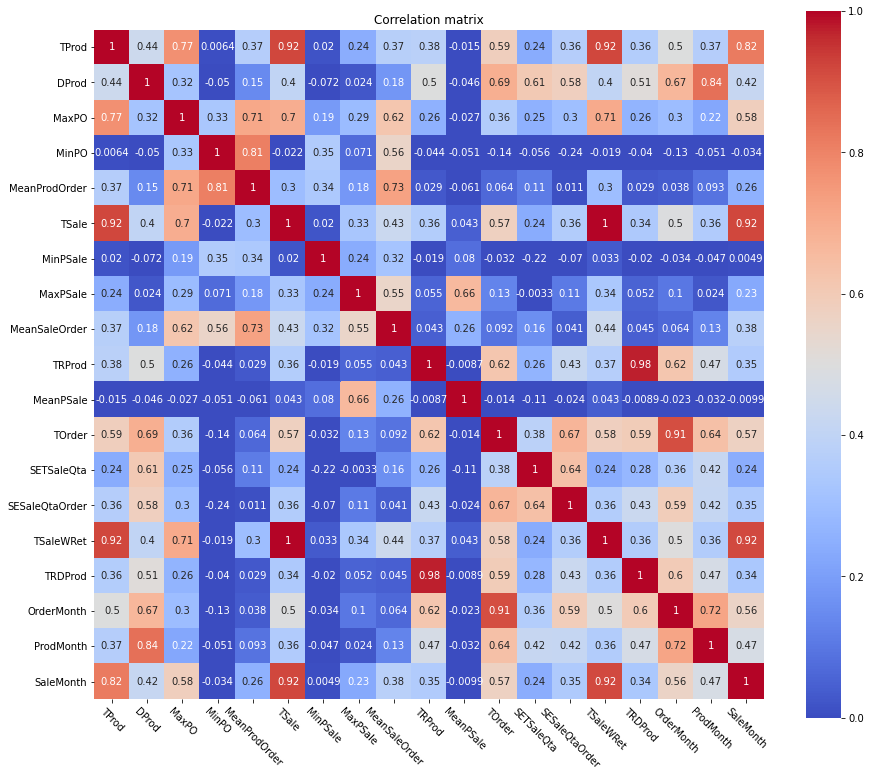

In [64]:
f, ax = plt.subplots(figsize=(15, 13))
correlation = data.corr()
sns.heatmap(correlation, cmap="coolwarm", vmin=0, vmax=1, annot=True, mask=np.zeros_like(correlation, dtype=np.bool), square=True, ax=ax, edgecolor='black')
plt.xticks(rotation=315)
plt.title("Correlation matrix")

In [65]:
data.drop(columns = ['OrderMonth', 'ProdMonth', 'SaleMonth', 'TSaleWRet', 'TRDProd'], inplace=True, errors='ignore')

Text(0.5, 1.0, 'Correlation matrix')

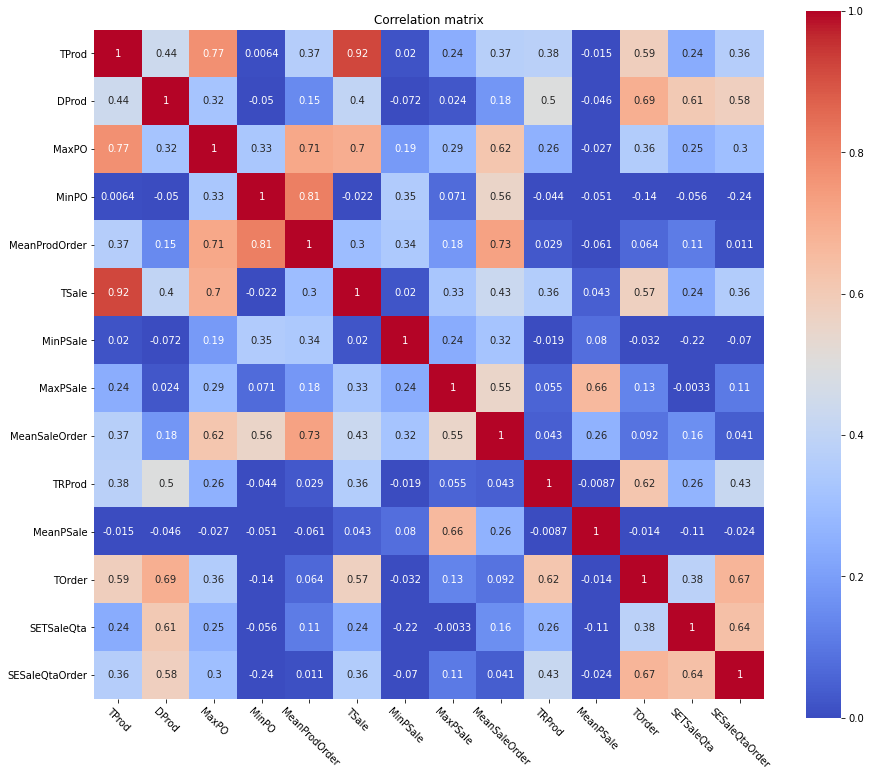

In [66]:
f, ax = plt.subplots(figsize=(15, 13))
correlation = data.corr()
sns.heatmap(correlation, cmap="coolwarm", vmin=0, vmax=1, annot=True, mask=np.zeros_like(correlation, dtype=np.bool), square=True, ax=ax, edgecolor='black')
plt.xticks(rotation=315)
plt.title("Correlation matrix")

**Saving customer-driven dataframe**

In [68]:
path = 'customer_dataframe.csv'
data.to_csv(path, sep='\t')
print(f"Customer dataframe saved to '{path}'")

Customer dataframe saved to 'customer_dataframe.csv'
